# Recursive implementation of WST in PyTorch

Here, instead of using FFT filters of same tensor size for all scales, we will cascade convolution with small kernels (average and details), similarly to a wavelet transform. We perform this cascade twice to get second order wavelet scattering coefficients. 

Convolutions are perfomred using `torch.nn.Conv2d`, preferably on the GPU.

⚠️ This is a work in progress, it seems that we don't extract as much information as when using FFT filters.

In [1]:
import datetime

import numpy as np

from skimage import io
from skimage.util import img_as_float32, img_as_ubyte

import torch
import torch.nn.functional as F
from torch import optim

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Selecting {device} as computing device.')

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

Selecting cuda as computing device.


## Load examples

We can try examples from histology (mesothelioma slides) or other textures.

In [2]:
# 
files = [
    'inputs/histology1_tiny.tiff',
    'inputs/histology3_tiny.tiff',
    'inputs/isotropic_turbulence_tiny.tiff',
    'inputs/shirt_tiny.tiff',
    'inputs/ifm_tiny.tiff',
]



In [3]:
images = []
for name in files:
    images.append(img_as_float32(io.imread(name)))

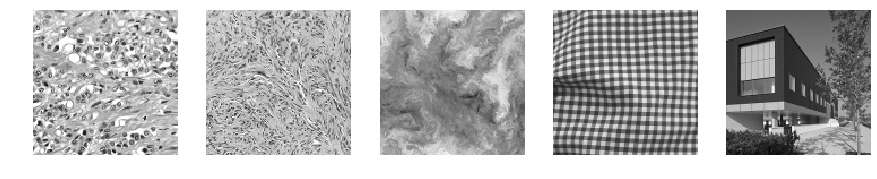

In [4]:
plt.rcParams["figure.figsize"] = (15,5)
figure, ax = plt.subplots(ncols=len(images))
for i, image in enumerate(images):
    ax[i].imshow(image, cmap='gray', vmin=0, vmax=1)
    ax[i].axis('off')
plt.show()

## Define wavelets (Gabor)

We only define the small scale wavelets (details and average) and cascade.

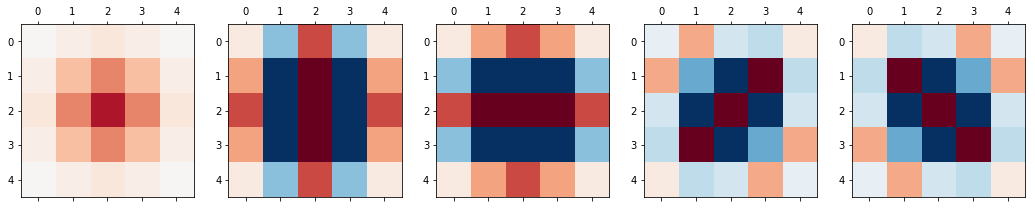

In [47]:
# Size of kernel
N = 5

# Define Gabor wavelets
x, y = np.meshgrid(np.arange(N), np.arange(N))

w0 = np.exp(-((x-N/2+0.5)**2+(y-N/2+0.5)**2)/2)


w1 = w0*(np.cos((x-N/2+0.5)*np.pi))
w1 = w0*(np.cos((x-N/2+0.5)*np.pi) - np.sum(w1)/np.sum(w0))

w2 = w0*np.cos((y-N/2+0.5)*np.pi)
w2 = w0*(np.cos((y-N/2+0.5)*np.pi) - np.sum(w2)/np.sum(w0))

w3 = w0*np.cos(((x-N/2+0.5)/np.sqrt(2)+(y-N/2+0.5)/np.sqrt(2))*np.pi)
w3 = w0*(np.cos(((x-N/2+0.5)/np.sqrt(2)+(y-N/2+0.5)/np.sqrt(2))*np.pi) - np.sum(w3)/np.sum(w0))

w4 = w0*np.cos(((x-N/2+0.5)/np.sqrt(2)-(y-N/2+0.5)/np.sqrt(2))*np.pi)
w4 = w0*(np.cos(((x-N/2+0.5)/np.sqrt(2)-(y-N/2+0.5)/np.sqrt(2))*np.pi) - np.sum(w4)/np.sum(w0))

# Normalize lowpass
w0 /= np.sum(w0)

figure, ax = plt.subplots(ncols=5)
amp = 0.2
ax[0].matshow(w0, cmap='RdBu_r', vmin=-amp, vmax=amp)
ax[1].matshow(w1, cmap='RdBu_r', vmin=-amp, vmax=amp)
ax[2].matshow(w2, cmap='RdBu_r', vmin=-amp, vmax=amp)
ax[3].matshow(w3, cmap='RdBu_r', vmin=-amp, vmax=amp)
ax[4].matshow(w4, cmap='RdBu_r', vmin=-amp, vmax=amp)
plt.show()


# Lets stack
weights = np.array([w0, w1, w2, w3, w4])
weights = np.expand_dims(weights, 1)
weights = weights.astype('float32')

In [48]:
dec = torch.nn.Conv2d(in_channels=1, 
                      out_channels=5, 
                      kernel_size=(N, N), 
                      stride=1, 
                      padding=N//2, 
                      dilation=1, 
                      groups=1, 
                      bias=False, 
                      padding_mode='reflect', 
                      device=device, 
                      dtype=None)

print(dec.weight.shape)
dec.weight = torch.nn.Parameter(torch.from_numpy(weights).to(device))

torch.Size([5, 1, 5, 5])


In [49]:
image = images[4]

input_ = torch.from_numpy(image[None, ...]).to(device)

output = dec(input_)

Lets have a look at the wavelet decomposition:

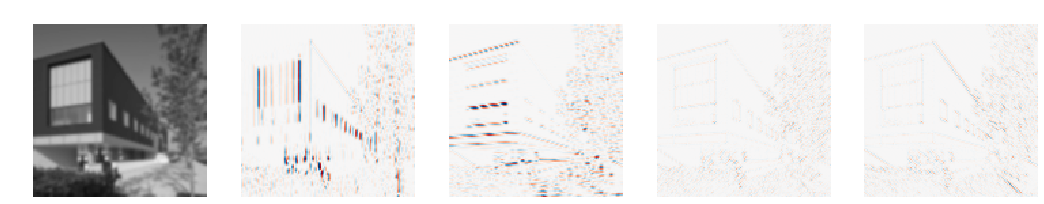

torch.Size([128, 128])


In [50]:
figure, ax = plt.subplots(ncols=5)
ax[0].matshow(output.detach()[0].cpu(), cmap='gray', vmin=0, vmax=1)
ax[0].axis('off')
ax[1].matshow(output.detach()[1].cpu(), cmap='RdBu_r', vmin=-1, vmax=1)
ax[1].axis('off')
ax[2].matshow(output.detach()[2].cpu(), cmap='RdBu_r', vmin=-1, vmax=1)
ax[2].axis('off')
ax[3].matshow(output.detach()[3].cpu(), cmap='RdBu_r', vmin=-1, vmax=1)
ax[3].axis('off')
ax[4].matshow(output.detach()[4].cpu(), cmap='RdBu_r', vmin=-1, vmax=1)
ax[4].axis('off')
plt.show()

print(output.detach()[0].shape)

### Recursive passes

We now define a wavelet scattering transform by applying a wavelet decomposition twice: a first time on the input image, a second time on the absolute value of each detail of the first pass.

In [51]:
m = torch.nn.AvgPool2d(2, stride=2)

def compute_wavelets(x):
    """Compute (non-orthogonal) wavelet decomposition, returns a flat list of torch.Tensor"""
    details = []
    input_ = x
    J = int(np.log2(x.shape[0]))
    for j in range(J-1):
        deco = dec(input_[None, ...])
        deco = m(deco)
        details.extend(list(deco[1+i] for i in range(4)))
        input_ = deco[0]
    return details + [input_]

def wavelet_moments(x):
    fieldss = []
    wavelet_dec = compute_wavelets(x)
    for wave in wavelet_dec:
        fieldss.append(compute_wavelets(torch.abs(wave)))
    
    moments = []
    for fields in fieldss:
        for field in fields:
            moments.append(torch.mean(torch.abs(field)))
    return torch.stack(moments)

In [52]:
wa = compute_wavelets(torch.from_numpy(image).to(device))

In [53]:
mo = wavelet_moments(torch.from_numpy(image).to(device))

In [54]:
len(mo)

265

## Microcanonical

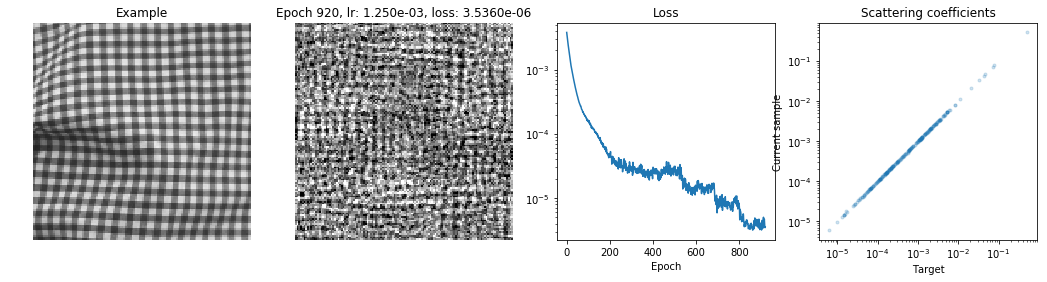

KeyboardInterrupt: 

In [46]:
# Image number
i = 3

image = images[i]
S0 = wavelet_moments(torch.from_numpy(image).to(device))
S0_plot = S0.detach().cpu()


# Create trainable input image
# ----------------------------

# From random values
x = torch.rand(image.shape, requires_grad=True, device=device)

# From low noise
#x = torch.full(image.shape, 0.5, requires_grad=True, device=device)
#with torch.no_grad():
#    x += 0.1*torch.randn(image.shape, device=device)
    

# Optional randomized matching power spectrum density
pre_filter = False
if pre_filter:
    with torch.no_grad():
        # Noise
        x_hat = torch.fft.fft2(x)
        x_psd = torch.abs(x_hat)**2
        # Example
        psd0 = torch.abs(torch.fft.fft2(torch.from_numpy(image).to(device).contiguous()))**2
        # Filter
        x_hat2 = x_hat*torch.sqrt(psd0/x_psd)
        # Inverse
        x = torch.real(torch.fft.ifft2(x_hat2)).contiguous()
    x.requires_grad_()


# Optimizer
# ---------
optimizer = optim.Adam([x], lr=0.01)
#optimizer = optim.SGD([x], lr=1e4, momentum=0.9, dampening=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100)


# Optimization loop
# -----------------
max_iter = 10_000
losses = []

for epoch in range(max_iter):
    S1 = wavelet_moments(x)
    #loss = F.mse_loss(input=S1, target=S0)
    #loss = F.smooth_l1_loss(input=S(x), target=S0, beta=1.3e-3)
    loss = F.l1_loss(input=S1, target=S0)
    loss.backward(retain_graph=True)
    optimizer.step()
    
    optimizer.zero_grad()
    scheduler.step(loss.item())
    losses.append(loss.item())
    
    if epoch%10==0:
        # Plotting
        current_image = x.detach().cpu().numpy()
        clear_output(wait=True)
        
        
        plt.rcParams["figure.figsize"] = (18,4)
        figure, ax = plt.subplots(ncols=4)
        ax[0].imshow(image, cmap='gray', vmin=0, vmax=1)
        ax[0].set_title("Example")
        ax[0].axis('off')

        ax[1].imshow(current_image, cmap='gray', vmin=0, vmax=1)
        #ax[1].set_title(f"Epoch {epoch}, lr: {scheduler.get_last_lr()[0]:1.6f}, loss: {loss.item():1.3e}")
        ax[1].set_title(f"Epoch {epoch}, lr: {scheduler._last_lr[0]:1.3e}, loss: {loss.item():1.4e}")
        ax[1].axis('off')

        if len(losses) < 50:
            ls = 'o-'
        else:
            ls = '-'
        ax[2].semilogy(losses, ls)
        ax[2].set_xlabel('Epoch')
        ax[2].set_title('Loss')
        
        
        ax[3].loglog(S0_plot, S1.detach().cpu(), '.', alpha=0.2)
        ax[3].set_title('Scattering coefficients')
        ax[3].set_xlabel('Target')
        ax[3].set_ylabel('Current sample')
        plt.show()